In [75]:
print("hello")

hello


In [76]:
import os

from IPython import display
#import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
import librosa

In [77]:
print(tf.__version__)

2.11.0


In [78]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)


In [79]:
testing_wav_file_name=tf.keras.utils.get_file('miaow_16k.wav',
                                              'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                              cache_dir="./",
                                              cache_subdir="test_data")
print(testing_wav_file_name)

./test_data\miaow_16k.wav


Need a function to load audio files, which will also be used later when working with the training data.

: The returned wav_data from load_wav_16k_mono is already normalized to values in the [-1.0, 1.0] range

In [80]:
def load_wav_16k_mono(filename):
    # Case 1: called via tf.numpy_function → NumPy array
    if isinstance(filename, (np.ndarray,)):
        filename = filename.item()

    # Case 2: Tensor (extra safety)
    if isinstance(filename, tf.Tensor):
        filename = filename.numpy().decode()

    audio, sr = librosa.load(
        filename,
        sr=16000,
        mono=True
    )
    return audio.astype("float32")

In [81]:
def load_wav_tf(filename):
    wav = tf.numpy_function(load_wav_16k_mono, [filename], tf.float32)
    wav.set_shape([None])
    return wav

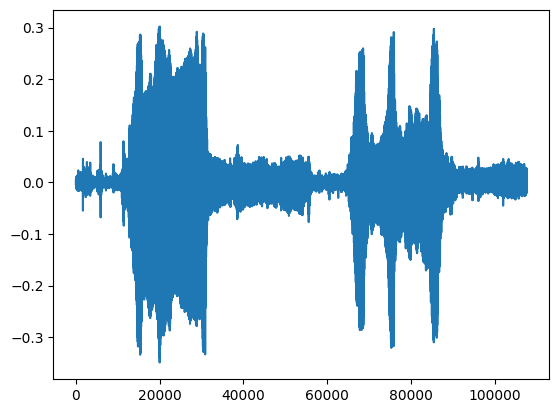

In [82]:
testing_wav_data = load_wav_tf(testing_wav_file_name)
_=plt.plot(testing_wav_data)
display.Audio(testing_wav_data,rate=16000)


Load the class mapping

It's important to load the class names that YAMNet is able to recognize. The mapping file is present at yamnet_model.class_map_path() in the CSV format.

In [83]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


Classes to watch out for :Glass , Smash, crash ,Breaking ,Crushing

YAMNet provides frame-level class-scores (i.e., 521 scores for every frame). In order to determine clip-level predictions, the scores can be aggregated per-class across frames (e.g., using mean or max aggregation). This is done below by scores_np.mean(axis=0). Finally, to find the top-scored class at the clip-level, you take the maximum of the 521 aggregated scores.

In [84]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Animal
The embeddings shape: (13, 1024)


Goal in this tutorial is to increase the model's accuracy for specific classes. Also, notice that the model generated 13 embeddings, 1 per frame.

Glass break dataset : is a labeled collection of 417 one-second long glass_break and background audio recordings. The dataset consists of 2 classes, with 200+ examples per class.

Explore the data:

The metadata for each file is specified in the csv file at /meta/esc50.csv and all the audio files are in /audio/

In [85]:
esc50_csv = 'meta_extended\esc50_extended.csv'
base_data_path = 'audio_extended'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-000001-A-0.wav,1,0,background,False,wat_042_00_00_2.wav,A
1,2-000002-A-0.wav,2,0,background,False,dra_097_02_01_0.wav,A
2,3-000003-A-0.wav,3,0,background,False,coo_043_00_00_0.wav,A
3,4-000004-A-0.wav,4,0,background,False,wal_043_00_10_3.wav,A
4,5-000005-A-0.wav,5,0,background,False,obj_104_00_05_0.wav,A


In [86]:
my_classes = ['background', 'glass_break']
map_class_to_id = {'background':0, 'glass_break':1}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,fold,target,category,esc10,src_file,take
0,audio_extended\1-000001-A-0.wav,1,0,background,False,wat_042_00_00_2.wav,A
1,audio_extended\2-000002-A-0.wav,2,0,background,False,dra_097_02_01_0.wav,A
2,audio_extended\3-000003-A-0.wav,3,0,background,False,coo_043_00_00_0.wav,A
3,audio_extended\4-000004-A-0.wav,4,0,background,False,wal_043_00_10_3.wav,A
4,audio_extended\5-000005-A-0.wav,5,0,background,False,obj_104_00_05_0.wav,A
5,audio_extended\1-000006-A-0.wav,1,0,background,False,dra_041_02_01_0.wav,A
6,audio_extended\2-000007-A-0.wav,2,0,background,False,was_004_00_00_0.wav,A
7,audio_extended\3-000008-A-0.wav,3,0,background,False,dis_098_00_00_0.wav,A
8,audio_extended\4-000009-A-0.wav,4,0,background,False,dra_034_01_01_0.wav,A
9,audio_extended\5-000010-A-0.wav,5,0,background,False,vac_003_00_00_0.wav,A


Load the audio files and retrieve embeddings

In [87]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [88]:
def load_wav_for_map(filename, label, fold):
  return load_wav_tf(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [89]:
# applies the embedding extraction model to wav data
def extract_embedding(wav_data, label, fold):
    """Run YAMNet to extract embeddings from wav data.
       Returns clip-level embeddings (T, 1024)."""
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    return embeddings, label, fold   # embeddings: (T, 1024)

In [90]:
# extract embeddings (NO unbatch)
main_ds = main_ds.map(extract_embedding)
main_ds.element_spec

(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Split the data

You will use the fold column to split the dataset into train, validation and test sets.

ESC-50 is arranged into five uniformly-sized cross-validation folds, such that clips from the same original source are always in the same fold

The last step is to remove the fold column from the dataset since you're not going to use it during training.

In [91]:
cached_ds = main_ds.cache()

train_ds = cached_ds.filter(lambda e, l, f: f <= 3)
val_ds   = cached_ds.filter(lambda e, l, f: f == 4)
test_ds  = cached_ds.filter(lambda e, l, f: f == 5)


# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds   = val_ds.map(remove_fold_column)
test_ds  = test_ds.map(remove_fold_column)

train_ds = (
    train_ds
    .cache()
    .shuffle(1000)
    .padded_batch(32, padded_shapes=([None, 1024], []))
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    val_ds
    .cache()
    .padded_batch(32, padded_shapes=([None, 1024], []))
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    test_ds
    .cache()
    .padded_batch(32, padded_shapes=([None, 1024], []))
    .prefetch(tf.data.AUTOTUNE)
)

In [92]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 1024), dtype=tf.float32),

    tf.keras.layers.Masking(mask_value=0.0),

    tf.keras.layers.GRU(
        256,
        return_sequences=False
    ),

    tf.keras.layers.Dense(512, activation="relu"),

    tf.keras.layers.Dense(
        len(my_classes),
        activation="softmax"
    )
], name="crnn_model")

my_model.summary()


Model: "crnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_3 (Masking)         (None, None, 1024)        0         
                                                                 
 gru_3 (GRU)                 (None, 256)               984576    
                                                                 
 dense_6 (Dense)             (None, 512)               131584    
                                                                 
 dense_7 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 1,117,186
Trainable params: 1,117,186
Non-trainable params: 0
_________________________________________________________________


In [93]:
my_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer="adam",
    metrics=["accuracy"]
)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [94]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20
94/94 [==============================] - 160s 1s/step - loss: 0.2856 - accuracy: 0.9464 - val_loss: 0.0773 - val_accuracy: 0.9678
Epoch 2/20
94/94 [==============================] - 4s 39ms/step - loss: 0.0440 - accuracy: 0.9889 - val_loss: 0.0499 - val_accuracy: 0.9789
Epoch 3/20
94/94 [==============================] - 4s 39ms/step - loss: 0.0423 - accuracy: 0.9852 - val_loss: 0.0359 - val_accuracy: 0.9879
Epoch 4/20
94/94 [==============================] - 4s 47ms/step - loss: 0.0298 - accuracy: 0.9909 - val_loss: 0.0389 - val_accuracy: 0.9889
Epoch 5/20
94/94 [==============================] - 4s 44ms/step - loss: 0.0187 - accuracy: 0.9940 - val_loss: 0.0241 - val_accuracy: 0.9909
Epoch 6/20
94/94 [==============================] - 4s 40ms/step - loss: 0.0147 - accuracy: 0.9950 - val_loss: 0.0316 - val_accuracy: 0.9920
Epoch 7/20
94/94 [==============================] - 4s 41ms/step - loss: 0.0180 - accuracy: 0.9930 - val_loss: 0.0206 - val_accuracy: 0.9920
Epoch 8/20
94

In [95]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

32/32 [==============================] - 1s 14ms/step - loss: 0.0577 - accuracy: 0.9728
Loss:  0.057746704667806625
Accuracy:  0.9728096723556519


In [96]:
import os
# Define the relative path to your file
relative_file_path = os.path.join("audio_extended", "5-004944-A-1.wav")

# tf.keras.utils.get_file is not needed here.
testing_wav_file_name1 = relative_file_path

print(testing_wav_file_name1)

audio_extended\5-004944-A-1.wav


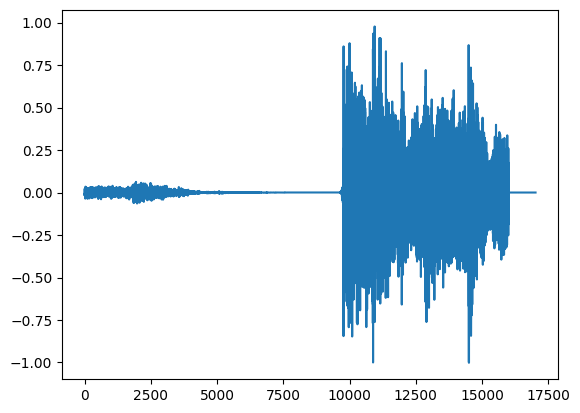

In [97]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name1)
_=plt.plot(testing_wav_data)
display.Audio(testing_wav_data,rate=16000)

In [100]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)

# Add batch dimension: (T, 1024) → (1, T, 1024)
embeddings = tf.expand_dims(embeddings, axis=0)

result = my_model(embeddings, training=False).numpy()

inferred_class = my_classes[result[0].argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: glass_break


Save a model that can directly take a WAV file as input

In [102]:
saved_model_path = "./glass_break_yamnet_GRU"

# Raw waveform input (1-D float32 tensor)
input_segment = tf.keras.layers.Input(
    shape=(),
    dtype=tf.float32,
    name="audio"
)

# YAMNet embedding extractor
yamnet_layer = hub.KerasLayer(
    yamnet_model_handle,
    trainable=False,
    name="yamnet"
)

# Run YAMNet
_, embeddings, _ = yamnet_layer(input_segment)
# embeddings: (time, 1024)

# Add batch dimension for CRNN
embeddings = tf.expand_dims(embeddings, axis=0)
# shape: (1, time, 1024)

# Run CRNN classifier
outputs = my_model(embeddings, training=False)
# shape: (1, num_classes)

# Build serving model
serving_model = tf.keras.Model(
    inputs=input_segment,
    outputs=outputs,
    name="yamnet_crnn_serving"
)

serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./glass_break_yamnet_GRU\assets


INFO:tensorflow:Assets written to: ./glass_break_yamnet_GRU\assets


In [103]:
reloaded_model = tf.saved_model.load("glass_break_yamnet_GRU")

In [105]:
reloaded_results = reloaded_model(testing_wav_data)
pred_idx = tf.argmax(reloaded_results, axis=-1).numpy()[0]
bg_or_glass = my_classes[pred_idx]
print(f'The main sound is: {bg_or_glass}')

The main sound is: glass_break


audio_extended\5-001870-A-0.wav
Waveform values: [-0.00037887 -0.00064766 -0.0005286  ... -0.00072935 -0.00074965
 -0.0007578 ]


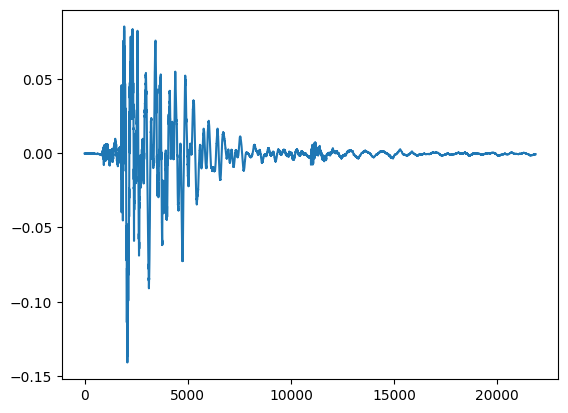

In [106]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 5]
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [107]:
# ---------- YAMNet baseline (unchanged, reference only) ----------
scores, embeddings, spectrogram = yamnet_model(waveform)

# YAMNet produces frame-level scores → average over time
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores).numpy()
inferred_class = class_names[top_class]
top_score = class_scores[top_class]

print(f"[YAMNet] The main sound is: {inferred_class} ({top_score:.4f})")


# ---------- Your CRNN model (UPDATED) ----------
reloaded_results = reloaded_model(waveform)
# shape: (1, num_classes)

# Get predicted class index (Option A – confirmed working)
your_top_class = tf.argmax(reloaded_results, axis=-1).numpy()[0]
your_inferred_class = my_classes[your_top_class]

# Output is already softmax probabilities
your_top_score = reloaded_results[0, your_top_class]

print(f"[Your model] The main sound is: {your_inferred_class} ({your_top_score:.4f})")

[YAMNet] The main sound is: Silence (0.5027)
[Your model] The main sound is: background (0.9954)
